# Глубинное обучение 1 / Введение в глубинное обучение, ФКН ВШЭ

## Домашнее задание 3: RNN и языковые модели

### Общая информация
### Оценивание и штрафы

Максимально допустимая оценка за работу — 10 баллов. Сдавать задание после указанного срока сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке. Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

### О задании

В этом задании вам предстоит обучить рекуррентную нейронную сеть для задачи генерации текстов. В качестве данных возьмем набор из 120 тысяч анекдотов (всех категорий от А до Я включительно). Его вы можете найти в архиве `jokes.txt.zip`, который доступен по [ссылке](https://disk.yandex.com/d/fjt5xICH-ukEEA).

In [2]:
%load_ext autoreload
%autoreload 2

In [1]:
!unzip ./hw3.zip

Archive:  ./hw3.zip
   creating: data/
   creating: data/external/
  inflating: data/external/jokes.txt  
   creating: src/
  inflating: src/model.py            
  inflating: src/train.py            
   creating: src/__pycache__/
  inflating: src/__pycache__/__init__.cpython-310.pyc  
  inflating: src/__pycache__/dataset.cpython-310.pyc  
  inflating: src/__pycache__/train.cpython-310.pyc  
  inflating: src/__pycache__/model.cpython-310.pyc  
  inflating: src/__init__.py         
  inflating: src/dataset.py          
  inflating: bpe_2000.model          
  inflating: bpe_2000.vocab          
  inflating: bpe_8000.model          
  inflating: bpe_8000.vocab          
  inflating: model_lstm.pt           
  inflating: model_lstm_bpe_large.pt  
  inflating: model_lstm_unigram.pt   
  inflating: model_rnn.pt            
  inflating: unigram_2000.model      
  inflating: unigram_2000.vocab      


## Задание 1: Dataset (1 балл)

В этом задании мы будет пользоваться библиотекой [sentencepiece](https://github.com/google/sentencepiece), которая поддерживает разные форматы токенизации текстов, в том числе BPE, который мы и будем использовать. Реализуйте недостающие фрагменты кода в классе `TextDataset` в файле `dataset.py`. Датасет обучает sentencepiece токенизатор, токенизирует тексты, превращает токены в индексы и паддит до одной и той же длины (параметр `max_length`). Не забудьте, что для генерации текстов нам будут нужны специальные токены начала и конца последовательности, соответственно `BOS` и `EOS`. Существуют еще два специальных токена &mdash; паддинг `PAD` и токен `UNK`, заменяющий out-of-vocabulary токены.

In [4]:
import torch
import numpy as np
from src.dataset import TextDataset

In [5]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cuda')

In [6]:
train_set = TextDataset(data_file='data/external/jokes.txt', train=True, sp_model_prefix='bpe_2000')
valid_set = TextDataset(data_file='data/external/jokes.txt', train=False, sp_model_prefix='bpe_2000')

In [ ]:
# Код должен проходить тесты
assert len(train_set) + len(valid_set) == 120759

for _ in range(5):
    for dataset in (train_set, valid_set):
        indices, length = dataset[np.random.randint(len(dataset))]
        assert indices.shape == (dataset.max_length, )
        assert indices[0].item() == dataset.bos_id
        assert (indices == dataset.eos_id).sum().item() == 1

        eos_pos = indices.tolist().index(dataset.eos_id)
        assert torch.all(indices[eos_pos + 1:] == dataset.pad_id)
        assert (indices != dataset.pad_id).sum() == length

## Задание 2 Language model (3.5 балла)

Реализуйте класс `LanguageModel` из файла `model.py`. Мы будем генерировать текст с помощью языковой модели &mdash; это авторегрессионная вероятностная модель, которая предсказывает распределение следующего токена при условии предыдущих:

$$
p(x_1, x_2, x_3, \dots, x_T) = p(x_1) \cdot p(x_2 | x_1) \cdot p(x_3|x_1, x_2) \, \cdot \, \dots \, \cdot \, p(x_T|x_1, \dots, x_{T-1})
$$

Мы будем реализовывать ее с помощью рекуррентной нейронной сети. Ваш код должен поддерживать возможность работать как с оригинальной [RNN](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html#torch.nn.RNN), так и c [LSTM](https://bitly.com/98K8eH). На каждом временном шаге модель возвращает логиты вероятностей для следующего токена. Модель будет работать в двух режимах (не путать с `.train()` и `.eval()`):

- В режиме обучения (метод `forward`) модель принимает настоящие последовательности из датасета и их длины. На каждом временном шаге возвращаются логиты вероятностей следующего токена, что позволяет считать лосс, обучаться на трейне и валидироваться на валидации.

- В режиме генерации (инференса, метод `inference`) модель принимает некоторый префикс (возможно пустой), с которого начинать генерацию, и продолжает его. Для этого на каждом шаге генерируются новые логиты, семплируется новый токен (из распределения, заданного логитами), и процесс продолжается, пока не будет сгенерирован токен `EOS` или не будет достигнуто ограничение на длину последовательности. **Обратите внимание**, что вам не нужно прогонять всю последовательность заново через RNN после каждого нового токена, это приведет к квадратичной сложности по длине последовательности. Вам достаточно обновлять скрытое состояние, подавая на вход новый сгенерированный токен и предыдущее скрытое состояние. Кроме того, чтобы получить больше контроля над генерацией, вводится параметр температуры `temp`. Перед семплированием нужно разделить на него логиты, полученные моделью.

In [17]:
from src.model import LanguageModel
model = LanguageModel(train_set)

In [18]:
# Код должен проходить тесты
for bs in [1, 4, 16, 64, 256]:
    indices = torch.randint(high=train_set.vocab_size, size=(bs, train_set.max_length))
    lengths = torch.randint(low=1, high=train_set.max_length + 1, size=(bs, ))
    logits = model(indices, lengths)
    assert logits.shape == (bs, lengths.max(), train_set.vocab_size)

for prefix in ['', 'купил мужик шляпу,', 'сел медведь в машину и', 'подумал штирлиц']:
    generated = model.inference(prefix)
    assert type(generated) == str
    assert generated.startswith(prefix)

## Задание 3: Training (1.5 балла)

Всё, что нам осталось &mdash; реализовать цикл обучения. Заполните пропуски в файле `train.py`. Не забудьте, что мы учим модель предсказывать вероятность следующего, а не текущего токена. Также рекомендуется обрезать батч индексов по самой длинной последовательности, чтобы не гонять паддинги вхолостую. Для оценки качества генерации будем использовать метрику [perplexity](https://towardsdatascience.com/perplexity-in-language-models-87a196019a94). Реализуйте ее подсчет в функции `plot_losses` (да, для этого достаточно только значения лосса).

Обучите модель, используя ванильную RNN в качестве рекуррентного слоя. Сохраните чекпойнт обученной модели, он нам еще пригодится.

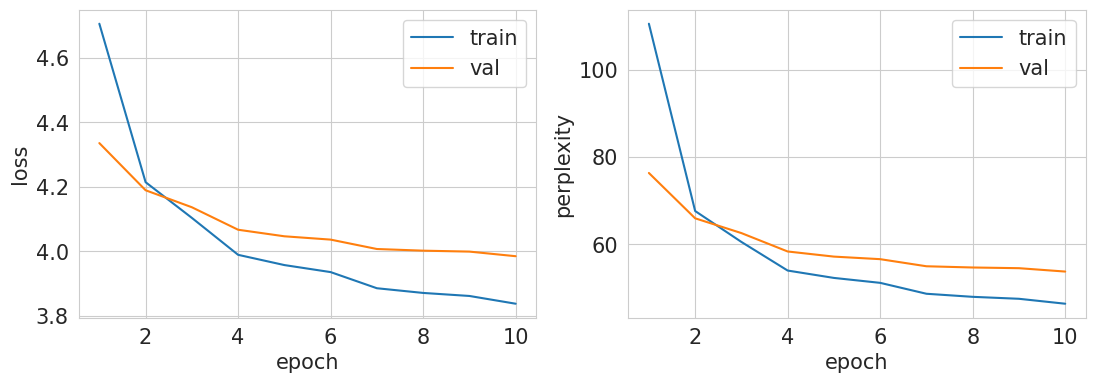

In [ ]:
import torch.optim as optim
from torch.utils.data import DataLoader
from src.train import train
from src.model import LanguageModel

model = LanguageModel(train_set)

learning_rate = 0.001
batch_size = 32
num_epochs = 10

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(valid_set, batch_size=batch_size)

train(model,
      optimizer,
      scheduler,
      train_loader,
      val_loader,
      num_epochs=num_epochs,
      device=DEVICE)
torch.save(model, "./model_rnn.pt")

## Задание 4: LSTM (0.5 балла)

Обучите аналогичную модель, но с LSTM в качестве рекуррентного слоя. Сравните модели по метрикам и генерации. Не забывайте про чекпойнты!

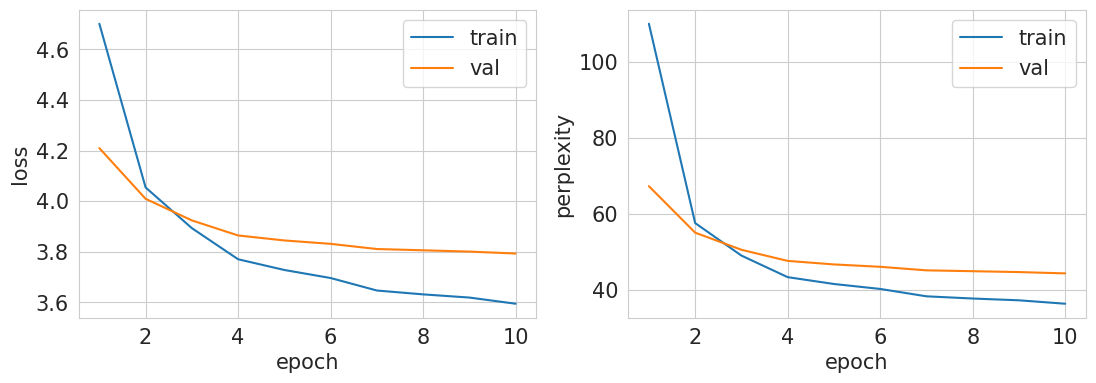

In [ ]:
import torch.optim as optim
from torch.utils.data import DataLoader
from torch import nn
from src.train import train
from src.model import LanguageModel

model = LanguageModel(train_set, rnn_type=nn.LSTM)

learning_rate = 0.001
batch_size = 32
num_epochs = 10

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(valid_set, batch_size=batch_size)

train(model,
      optimizer,
      scheduler,
      train_loader,
      val_loader,
      num_epochs=num_epochs,
      device=DEVICE)
torch.save(model, "./model_lstm.pt")

После изменения рекурентного слоя с RNN на LSTM, метрика улучшилась на 20% (perplexity с ~55 уменьшилось до ~45 на валидационной выборке)

## Задание 5: Sampling temperature (0.5 балла)

Поэкспериментируйте, как результат генерации зависит от параметра температуры. Попробуйте генерацию с разными префиксами. Сделайте выводы.

In [ ]:
model = torch.load("model_lstm.pt").to(torch.device("cpu")) # Подгрузим модель с LSTM

### Prefix про Штирлица

In [ ]:
prefix_shtirlets = "Штирлиц еще никогда не был так близок к провалу"

In [ ]:
model.inference(prefix_shtirlets, temp=0.1)

'штирлиц еще никогда не был так близок к провалую горячим наложил.'

In [ ]:
model.inference(prefix_shtirlets, temp=0.01)

'штирлиц еще никогда не был так близок к провалую, гладитку в нулевый, это дело для проценты.'

In [ ]:
model.inference(prefix_shtirlets, temp=0.001)

'штирлиц еще никогда не был так близок к провалую.'

In [ ]:
model.inference(prefix_shtirlets, temp=2)

'штирлиц еще никогда не был так близок к провалу...отс и она родил института.'

In [ ]:
model.inference(prefix_shtirlets, temp=20)

'штирлиц еще никогда не был так близок к провалу можешь начинаться девственничности вводить, мне спать приходит домой в наш города, как спать.'

In [ ]:
model.inference(prefix_shtirlets, temp=100)

'штирлиц еще никогда не был так близок к провалуут и мертвым детских выборах, тоже сказал, что будете не участинных женщин, на которую будет убить, какого цветческих.'

### Prefix про русского, американца и француза

In [ ]:
prefix_rus_us_fr = "Как-то русский, француз и американец"

In [ ]:
model.inference(prefix_rus_us_fr, temp=0.1)

'как-то русский, француз и американец- только заварили друзей бить рам.'

In [ ]:
model.inference(prefix_rus_us_fr, temp=0.01)

'как-то русский, француз и американец- больной, на улице хорошо, приезжайте на диване и убиваешь. а вам говорят?'

In [ ]:
model.inference(prefix_rus_us_fr, temp=0.001)

'как-то русский, француз и американец- чубайсарь большой видом моется мою машину, а утром сложилась во второй, куда хорошо. когда краснеет, бабульчик заглядывает машину. она видит. еще более дракон.'

In [ ]:
model.inference(prefix_rus_us_fr, temp=2)

'как-то русский, француз и американец мимо паника нельзя давать у них в зимней семье спализу нулевой?'

In [ ]:
model.inference(prefix_rus_us_fr, temp=20)

'как-то русский, француз и американец слушал чащетоп  ⁇ 0 с предупредил.'

In [ ]:
model.inference(prefix_rus_us_fr, temp=100)

'как-то русский, француз и американец молока- чему?- да нет, вот купи мужу. вчера наконец-то у меня аварий выбирает и потом жарится.'

В целом, можно сказать, что чем выше температура, тем более длинные ответы генерируются и более неуместные слова и символы появляются в сгенерированном примере. При больших температурах возможно могут появляться новые слова, составленные из подслов

## Задание 5: Tokenizers (1 балл)

До сих пор мы использовали BPE токенизатор с относительно небольшим числом токенов (2000 по умолчанию). Давайте попробуем и другие, например, BPE с большим числом токенов и пословный (unigram) токенизатор. Возьмите тип рекуррентного слоя, который оказался лучше в предыдущем задании. Обучите модели на таких токенизаторах и сравните их генерацию. Не забывайте сохранять чекпойнты. Правильно ли сравнивать между собой получившиеся модели по значению perplexity? Почему?

Обучим BPE токенизатор с числом токенов 8000

In [ ]:
from src.dataset import TextDataset

train_set_bpe_large = TextDataset(data_file='data/external/jokes.txt',
                                  train=True,
                                  sp_model_prefix='bpe_8000',
                                  vocab_size=8000)
valid_set_bpe_large = TextDataset(data_file='data/external/jokes.txt',
                                  train=False,
                                  sp_model_prefix='bpe_8000',
                                  vocab_size=8000)

Обучим LSTM модель с новым BPE токенизатором с 8000 токенов

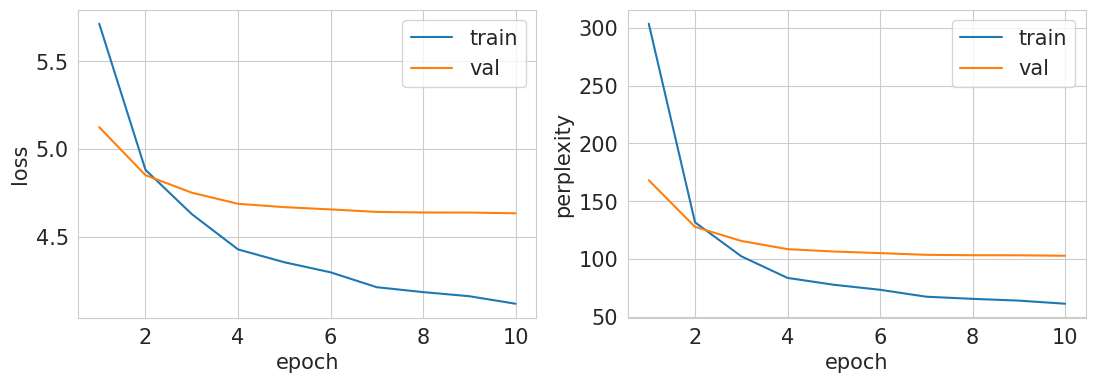

NameError: name 'model' is not defined

In [ ]:
import torch.optim as optim
from torch.utils.data import DataLoader
from src.train import train
from torch import nn
from src.model import LanguageModel

model_bpe_large = LanguageModel(train_set_bpe_large, rnn_type=nn.LSTM)

learning_rate = 0.001
batch_size = 32
num_epochs = 10

optimizer = optim.Adam(model_bpe_large.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)

train_loader_bpe_large = DataLoader(train_set_bpe_large, batch_size=batch_size, shuffle=True)
val_loader_bpe_large = DataLoader(valid_set_bpe_large, batch_size=batch_size)

train(model_bpe_large,
      optimizer,
      scheduler,
      train_loader_bpe_large,
      val_loader_bpe_large,
      num_epochs=num_epochs,
      device=DEVICE)
torch.save(model_bpe_large, "./model_lstm_bpe_large.pt")

Обучим unigram токенизатор с числом токенов 2000

In [10]:
from src.dataset import TextDataset

train_set_unigram = TextDataset(data_file='data/external/jokes.txt',
                                  train=True,
                                  model_type="unigram",
                                  sp_model_prefix='unigram_2000',
                                  vocab_size=2000)
valid_set_unigram = TextDataset(data_file='data/external/jokes.txt',
                                  train=False,
                                  model_type="unigram",
                                  sp_model_prefix='unigram_2000',
                                  vocab_size=2000)

Обучим LSTM модель с unigram токенизатором с 8000 токенов

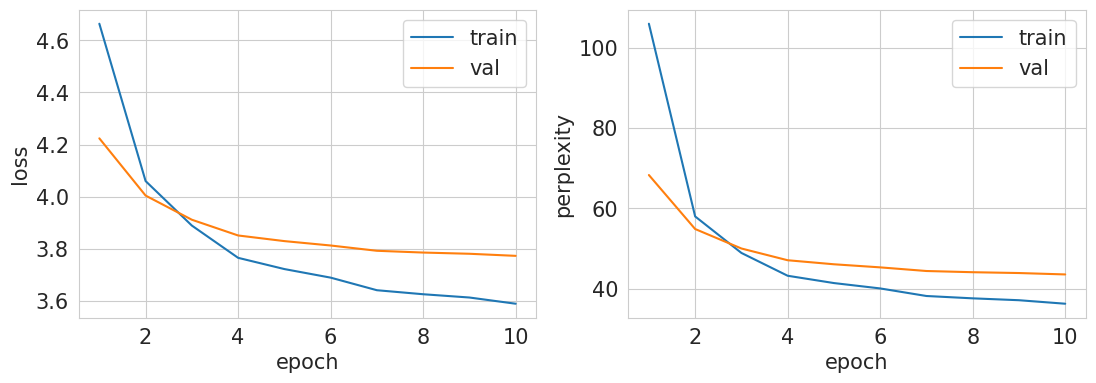

In [4]:
import torch.optim as optim
from torch.utils.data import DataLoader
from src.train import train
from torch import nn
from src.model import LanguageModel

model_unigram = LanguageModel(train_set_unigram, rnn_type=nn.LSTM)

learning_rate = 0.001
batch_size = 32
num_epochs = 10

optimizer = optim.Adam(model_unigram.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)

train_loader_unigram = DataLoader(train_set_unigram, batch_size=batch_size, shuffle=True)
val_loader_unigram = DataLoader(valid_set_unigram, batch_size=batch_size)

train(model_unigram,
      optimizer,
      scheduler,
      train_loader_unigram,
      val_loader_unigram,
      num_epochs=num_epochs,
      device=DEVICE)
torch.save(model_unigram, "./model_lstm_unigram.pt")

Метрика perplexity рассчитывается как:
$$PPL(X)=\exp\{−\frac{1}{t}​\sum\limits_{i}^{t}​\log{p_θ}​(x_i​∣x_{<i}​)\}$$

<center>
где $x_i$ - $i$-й токен,
$x_{<i}$ - предшествующий $i$-ому токену набор токенов
</center>


Предсказательная способность модели расчитывается на уровне токенов. У разных токенизаторов формируется разный набор токенов, а следовательно, сравнение неэквивалентных наборов токенов может привести к нечестному сравнению предсказательной способности двух моделей, так как модели обучаются предсказывать разные токены. Поэтому сравнивать perplexity двух получившихся моделей не совсем верно

## Задание 6. Latent Semantic Analysis (1 балл)

Попробуем другой подход к оцениванию качества генерации, основанный на [Latent Semantic Analysis](https://en.wikipedia.org/wiki/Latent_semantic_analysis). Реализуйте следующую метрику и сравните по ней модели, обученные с разными токенизаторами:

1. Генерируем обученной моделью выборку текстов, совпадающую по размеру с валидационной выборкой.
2. Объединяем две выборки текстов (валидационную и сгенерированную) в один корпус. Обратите внимание, что наша токенизация в общем случае необратима, поэтому для чистоты эксперимента нужно закодировать и декодировать валидационную выборку.
3. Генерируем tf-idf матрицу для полученного корпуса.
4. Понижаем размерность матрицы с помощью [SVD](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html).
5. Теперь у нас есть векторы, описывающие валидационные и сгенерированные тексты, лежащие в одном пространстве. Для каждого вектора, отвечающего сгенерированному тексту, найдем наибольший cosine similarity между ним и вектором валидационного текста. Усредним такие similarity по всем сгенерированным текстам и получим число, характеризующее похожесть сгенерированной выборки на валидационную.

Какие плюсы и минусы есть у описанной метрики?

### Генерация обученной моделью выборки текстов

In [43]:
from src.dataset import TextDataset

valid_set_lsa = TextDataset(data_file='data/external/jokes.txt', train=False, sp_model_prefix='unigram_2000')

Возьмем из каждого текста валидационной выборке по два первых слова для подачи prefix на вход модели

In [44]:
from string import punctuation

train_prefixes = list(map(lambda x: ' '.join(x.translate(str.maketrans('', '', punctuation)).strip().split()[:2]), valid_set_lsa.texts))
print(train_prefixes[:5])

['Древние киргизы', 'Все мужчины', 'Витя почему', 'Брак это', 'Девушка девушка']


Подгрузим обученную модель (LSTM с токенизацией unigram, размер словаря 2000) и сгенерируем по полученным prefix'ам тексты

In [47]:
import torch
from torch import nn

# Подгружаем обученную модель
model_lsa = torch.load("model_lstm_unigram.pt", map_location=torch.device('cpu'))
model_lsa.inference(prefix)

generated_texts = []
for prefix in train_prefixes:
  generated = model_lsa.inference(prefix)
  generated_texts.append(generated)

Посмотрим на несколько первых сгенерированных обученной моделью текстов и сохраним в файл

In [48]:
generated_texts[:5]

['древние киргизывн которым приличным урок расшибки на полгода.',
 'все мужчины время обед геологи бских самоезде обручальное место, а от того, что и белые и попробовать его по статистике.',
 'витя почемум покажусье пообещали за что до ручки?',
 'брак этоляции командеры приложите колдунья - обама нельзя. аналодира спортсмен пытался прекрасными карному аист у друга для умного, дыхание...',
 'девушка девушкай школьной девушке- сэр! мне в плохой неделе мужчине хочешь всего у меня. мне хватает-ту...- это правда?! а мать - я бы сказал, как о твоей работе были!']

In [3]:
with open("data/interim/lsa_generated_jokes.txt", "w") as f:
  for gen_text in generated_texts:
    f.write(f"{gen_text}\n")

# with open("data/interim/lsa_generated_jokes.txt", "r") as f:
#     generated_texts = f.readlines()

### Объединение двух выборок в один корпус

Декодируем валидационную выборку в текст и сохраним в файл

In [54]:
decode_val_texts = list(map(lambda x: valid_set_lsa.ids2text(x), valid_set_lsa.texts))
decode_val_texts[:5]

['Древние киргизы ничего не знали о существовании евреев, поэтому все происходившие с ними беды относили на счет темных сил природы...\n',
 'Все мужчины одинаковые. Разные лица у них только для того, чтобы женщины могли их различать.\n',
 '- Витя, почему у тебя одно ухо больше другого?- Это когда я родился - меня безменом взвешивали.\n',
 'Брак - это уговаривать одну и ту же женщину каждый день.\n',
 '- Девушка, девушка! Скажи телефон, я запомню!- Ну запоминай, математик восемьдесят девять миллиардов сто двадцать семь миллионов семьсот девяносто четыре тысячи сто пятьдесят три.\n']

In [2]:
with open("data/interim/lsa_val_jokes.txt", "w") as f:
  for val_text in decode_val_texts:
    f.write(val_text)

# with open("data/interim/lsa_val_jokes.txt", "r") as f:
#     decode_val_texts = f.readlines()

Объединим две выборки в один список

In [4]:
lsa_corpus = []
lsa_corpus.extend(decode_val_texts)
lsa_corpus.extend(generated_texts)
len(lsa_corpus)

12074

### Генерация TF-IDF матрицы

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
tf_idf_corpus = vectorizer.fit_transform(lsa_corpus)

feature_names = vectorizer.get_feature_names_out()
lsa_corpus_matrix = tf_idf_corpus.toarray()

print(lsa_corpus_matrix)

print(feature_names)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
['00' '000' '0200' ... 'ящики' 'ящикость' 'яя']


### Понижение размерности с помощью SVD

In [7]:
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix

lsa_corpus_csr_matrix = csr_matrix(lsa_corpus_matrix)
svd = TruncatedSVD(n_components=2000, n_iter=7, random_state=42)
svd.fit(lsa_corpus_csr_matrix)
print(svd.explained_variance_ratio_.sum())

0.48742723026351703


In [8]:
lsa_corpus_svd = svd.transform(lsa_corpus_csr_matrix)

Получим сжатые матрицы для каждой выборки отдельно

In [11]:
n_texts = len(decode_val_texts)

val_svd = lsa_corpus_svd[:n_texts]
generated_svd = lsa_corpus_svd[n_texts:]

### Расчет косинусного расстояния между текстами выборок и метрики похожести

In [45]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

cos_sim_result = cosine_similarity(generated_svd, val_svd)
most_similar_indices = np.argmax(cos_sim_result, axis=1)
biggest_cos_sim = cos_sim_result[np.arange(cos_sim_result.shape[0]), most_similar_indices]

In [46]:
sim_metric_value = np.mean(biggest_cos_sim)
print(f"Похожесть сгенерированной выборки на валидационную: {sim_metric_value}")

Похожесть сгенерированной выборки на валидационную: 0.39298566798961615


In [51]:
for i, gen_text in enumerate(generated_texts[:5]):
    print(
        f"""
        Сгенерированный текст:
        {gen_text}
        {"-"*80}
        Самый похожий валидационный текст:
        {decode_val_texts[most_similar_indices[i]]}
        {"="*80}
    """
    )


        Сгенерированный текст:
        древние киргизывн которым приличным урок расшибки на полгода.

        --------------------------------------------------------------------------------
        Самый похожий валидационный текст:
        Полгода отработала в борделе - и поняла ошиблась, не мое.

    

        Сгенерированный текст:
        все мужчины время обед геологи бских самоезде обручальное место, а от того, что и белые и попробовать его по статистике.

        --------------------------------------------------------------------------------
        Самый похожий валидационный текст:
        Мужчины носят обручальное кольцо, чтобы им сочувствовали друзья.

    

        Сгенерированный текст:
        витя почемум покажусье пообещали за что до ручки?

        --------------------------------------------------------------------------------
        Самый похожий валидационный текст:
        Леня, Леня, Витя, Витя... История Украины становится предсказуемой.

    

        Сгенер

### Выводы о метрике
Как метрика качества генерации текста метрика скорее не подходит, но позволяет оценить насколько модель способна сгенерировать тексты, похожие на реальные с точки зрения наличия похожих слов (в том числе учитыва синонимы). Однако, она не учитывает, например, порядок слов, что важно, так как набор слов в сгенерированном тексте может совпадать с набором словам из влидационного текста, но по смыслу сгенерированное предложение не будет иметь смысл. Также метрика неабсолютная и будет зависить от валидационной выборки и модели с разными валидационными выборками сравнивать будет неправильно.

## Задание 7. Visualization (1 балл)

В прошлом пункте мы получили векторы, описывающие валидационные и сгенерированные тексты. Попробуем визуализировать их. Примените [TSNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) к этим векторам и нарисуйте scatter-plot с получившимися двумерными представлениями. Точки, соответствующие валидационным и сгенерированным текстам, должны быть разного цвета. Визуализируйте таким образом все три модели для разных токенизаторов.

In [ ]:
# YOUR CODE HERE (⊃｡•́‿•̀｡)⊃━✿✿✿✿✿✿

## Бонус (0.1 балл)

Покажите лучший анекдот, который удалось сгенерировать вашей модели. Если проверяющий найдет его смешным, то поставит 0.1 балла.